## Resources
http://cs229.stanford.edu/notes/cs229-notes7b.pdf

https://people.eecs.berkeley.edu/~pabbeel/cs287-fa13/slides/Likelihood_EM_HMM_Kalman.pdf

https://www2.ee.washington.edu/techsite/papers/documents/UWEETR-2010-0002.pdf


In [64]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [158]:
#colors = ['orange', 'green', 'red']#, 'blue', 'majent']


#def make_ellipses(means, covs, ax):
def make_ellipses(means, covs, ax, color='b'):
    ells = []
#    for i, color in enumerate(colors):
    for i in range(means.shape[0]):
        mean = means[i]
        cov = covs[i]
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1],180 + angle, color=color, label='Cluster k = {}'.format(i))
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ells.append(ell)
    return ells



def gmm_contours(gmm, data, axis=0, domain=[-10,10,-10,10], cmap=None, color=None, filename=None):
    # display predicted scores by the model as a contour plot
    x = np.linspace(domain[0], domain[1])
    y = np.linspace(domain[2], domain[3])
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    Z = gmm.eval(XX, axis=axis)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10), cmap=cmap)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(data[:, 0], data[:, 1], .8, color=color)

    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')
    if filename:
        plt.savefig(filename)
    plt.show()

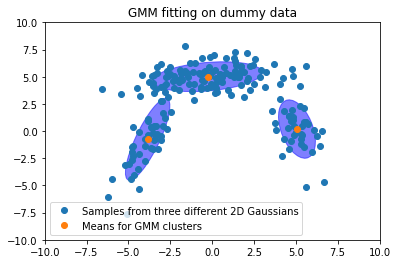

In [135]:
# np.random.seed(42)

means = np.array([
         [0.0, 5.0],
         [5.0, 0.0],
         [-4.0, -1.0],
        ])
          
covs = np.array([
        [[5.0, 0.0],[0.0, 1.0]],
        [[1.0, -1.0],[-1.0, 3.0]],
        [[1.0, 2.0],[2.0, 6.0]]
       ])

N = 200
D = means.shape[1]
K = means.shape[0]

data = np.ndarray([N, D])
# TODO: could convert to func to apply_along_axis
for i in range(N):
#     j = np.random.randint(0, K)
    j = np.random.choice([0, 1, 2], p=[0.6, 0.2, 0.2])
    data[i] = np.random.multivariate_normal(means[j], covs[j])
    
from gmm import GMM
gmm = GMM()
ll, gamma = gmm.fit(data, 3)
pred_means, pred_covs = gmm.mu, gmm.Sigma 

x, y = np.hsplit(data, 2)
px, py = np.hsplit(pred_means, 2)


p1 = plt.plot(x, y,'o', label='Samples from three different 2D Gaussians')[0]
p2 = plt.plot(px, py,'o', label='Means for GMM clusters')[0]
plt.axis([-10, 10, -10, 10])
ax = plt.gca()
ells = make_ellipses(pred_means, pred_covs, ax)
ells = [p1, p2]
plt.legend(ells, [thing.get_label() for thing in ells])
plt.title('GMM fitting on dummy data')
# plt.legend()
# ax.legend()
plt.savefig('gmm_fit.png')
plt.show()

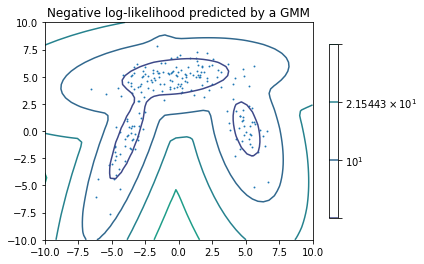

In [140]:
gmm_contours(gmm, data, 0, cmap='viridis')

In [68]:
gmm

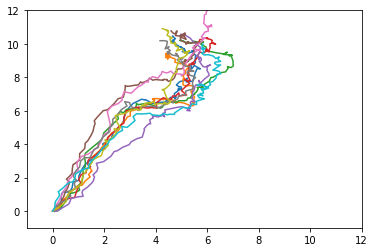

In [166]:
# create trajectory
class TrajGen(object):
    def __init__(self, init_x):
        """
        Params:
            init_x (np.ndarray): (D,)
        """
        self.x = init_x
        
    def step(self, t):
        if t <= 30:
            u = np.array([0.1, 0.2])
        elif t > 30 and t <= 50:
            u = np.array([0.1, 0.03])
        elif t > 50 and t <= 70:
            u = np.array([0.03, 0.1])
        else:
            u = np.array([-0.03, 0.05])
            
        self.x = self.x + u + np.random.normal([0,0],0.1)
        return u, self.x
    

D = 2
X = np.zeros([10, 100, D])
U = np.zeros([10, 100, D])

for i in range(X.shape[0]):
    tg = TrajGen(np.array([0, 0]))
    X[i,0] = tg.x
    for t in range(99):
        u, x_ = tg.step(t)
        U[i, t] = u
        X[i, t+1] = x_
    plt.plot(X[i,:,0], X[i,:,1])
plt.axis([-1, 12, -1, 12])
plt.show()

In [70]:
traj_gmm = GMM()

T = X.shape[1] - 1
# Compute cluster dimensionality.
Do = X.shape[2] + U.shape[2] + X.shape[2]

# Create dataset.
N = X.shape[0]
xux = np.reshape(
    np.c_[X[:, :T, :], U[:, :T, :], X[:, 1:(T+1), :]],
    [T * N, Do]
)

traj_gmm.fit(xux, 4)[0]

4924.9194269607042

In [71]:
traj_gmm.mu[0]

array([ 4.2129235 ,  6.19279201,  0.1       ,  0.03      ,  4.32215282,
        6.21940215])

In [72]:
traj_gmm.mu[0][0], traj_gmm.mu[0][1]

(4.2129234950612391, 6.1927920144655921)

In [73]:
gmm.Sigma.shape

(3, 2, 2)

In [74]:
traj_gmm.Sigma[:, :2, :2].shape

(4, 2, 2)

In [75]:
traj_gmm.mu[0,2:4]

array([ 0.1 ,  0.03])

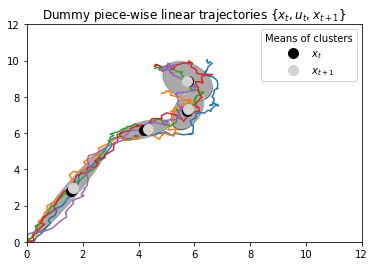

In [83]:
for i in range(X.shape[0]):
    plt.plot(X[i,:,0], X[i,:,1])
    
ax = plt.gca()
plt.axis([0, 12, 0, 12])
ells = make_ellipses(traj_gmm.mu[:,:2], traj_gmm.Sigma[:,:2,:2], ax, color='black')
ells = make_ellipses(traj_gmm.mu[:,4:], traj_gmm.Sigma[:,4:,4:], ax, color='lightgray')
#ells = make_ellipses(traj_gmm.mu[:,:2]+traj_gmm.mu[:,2:4], 100*traj_gmm.Sigma[:,2:4,2:4], ax, color='red')

plt.plot(traj_gmm.mu[:,0], traj_gmm.mu[:,1], 'o', color='black', ms=10, label=r'$x_t$')
# plt.plot(traj_gmm.mu[:,0]+traj_gmm.mu[:,2], traj_gmm.mu[:,1]+traj_gmm.mu[:,3], 'o', color='red', ms=10, label=r'$u_t$')
plt.plot(traj_gmm.mu[:,-2], traj_gmm.mu[:,-1], 'o', color='lightgray', ms=10, label=r'$x_{t+1}$')
plt.title(r'Dummy piece-wise linear trajectories $\{x_t, u_t, x_{t+1}\}$')
# plt.savefig('traj4.png')
plt.legend(title='Means of clusters')
plt.show()

In [77]:
xux.shape

(495, 6)

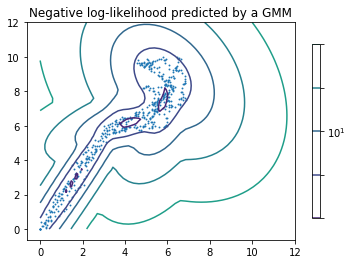

In [160]:
# gmm_contours(traj_gmm, xux[:, 4:], domain=[0, 12, 0, 12], filename='traj4_next_contours.png')
gmm_contours(traj_gmm, xux[:, :2], axis=0, domain=[0, 12, 0, 12], cmap='viridis', color='C0')
# gmm_contours(traj_gmm, xux[:, 4:], axis=2, domain=[0, 12, 0, 12], cmap='plasma', color='C4')
plt.show()
# gmm_contours(traj_gmm, xux[:, :2], domain=[0, 12, 0, 12], filename='traj4_contours.png')

In [ ]:
traj_gmm.predict()

# Scratch work

In [204]:
from scipy.stats import multivariate_normal
# E-step
N = data.shape[0]

# gamma[i][j] is estimated probability of ith sample belonging to jth Gaussian
gamma = np.zeros([N, K])

for i in range(N):
    for j in range(K):
        mvar = multivariate_normal(gmm.mu[j], gmm.Sigma[j])
        gamma[i][j] = gmm.weights[j] * mvar.pdf(data[i])
    gamma[i, :] /= np.sum(gamma[i, :])

    assert np.isclose(1, np.sum(gamma[i, :]))


In [ ]:
mvar.pdf(data).shape

In [ ]:
gamma[:, j].shape

In [ ]:
N = data.shape[0]
# gamma[i][j] is estimated probability of ith sample belonging to jth Gaussian

gamma = np.zeros([N, K])
for i in range(N):
    for j in range(K):
        mvar = multivariate_normal(gmm.mu[j], gmm.Sigma[j])
        gamma[i][j] = gmm.weights[j] * mvar.pdf(data[i])
    gamma[i, :] /= np.sum(gamma[i, :])

    assert np.isclose(1, np.sum(gamma[i, :]))

save_gamma = gamma

In [ ]:
gamma = np.zeros([K, N])
for j in range(K):
    mvar = multivariate_normal(gmm.mu[j], gmm.Sigma[j])
    gamma[j, :] = gmm.weights[j] * mvar.pdf(data)
row_sums = gamma.sum(axis=0)
gamma = gamma / row_sums[np.newaxis, :]

In [ ]:
np.sum(save_gamma - gamma.T)

In [ ]:
%%timeit
gamma = np.zeros([K, N])
def comp_pdf(row, j):
    mvar = multivariate_normal(gmm.mu[j], gmm.Sigma[j])
    row = mvar.pdf(data)
    
np.apply_along_axis(comp_pdf, 1, gamma, 0)
    
row_sums = gamma.sum(axis=1)
gamma = gamma / row_sums[:, np.newaxis]

In [ ]:

test_data.shape

In [ ]:
test_data = np.random.multivariate_normal(means[0], covs[0], size=10)
gmm.predict(test_data)

In [ ]:
np.sum(np.array([1.0, 3.0, 6.0]), axis=0)

In [ ]:
np.sum(gamma, 0) / np.sum(gamma)

In [ ]:
ugmm.mu

In [ ]:
gmm.weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(data)

# display predicted scores by the model as a contour plot
x = np.linspace(-10., 10.)
y = np.linspace(-10., 10.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(data[:, 0], data[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


In [ ]:
clf.predict(data[:7])

In [ ]:
gmm.mu

In [ ]:
weight_update

In [ ]:
means

In [ ]:
covs

In [ ]:
gmm.fit(data,K)

In [ ]:
weigh_update, mu_update, Sigma_update = gmm.fit(data, K)

In [ ]:
Sigma_update

In [ ]:
weigh_update, mu_update, Sigma_update = gmm.fit(data, K)

In [ ]:
Sigma_update[:, np.arange(D), np.arange(D)] *= n_inv

In [ ]:
Sigma_update

In [ ]:
gmm.fit(data, K)

In [ ]:
Sigma_update.shape

In [ ]:
gmm = GMM()
ll = gmm.fit(data, 3)

In [ ]:
means

In [ ]:
gmm.mu

In [ ]:
covs

In [ ]:
gmm.Sigma

In [ ]:
ll

In [ ]:
mu_update[j]

In [ ]:
diff.dot(diff.T)

In [ ]:
Sigma_update = np.zeros([K, D, D])

for j in range(K):
    for i in range(N):
        diff = (data[i] - mu_update[j])[np.newaxis, :]
        Sigma_update[j, :, :] += gamma[i][j]*(diff.T.dot(diff))

In [ ]:
Sigma_update

In [ ]:
np.dot(gamma.T, np.dot(diff, diff.T)).shape

In [ ]:
np.dot(gamma.T, diff)

In [ ]:
n_inv

In [ ]:
np.dot(diff, diff.T).shape

In [ ]:
Sigma_update[j, :, :] = (n_inv * np.dot(gamma.T, np.dot(diff, diff.T))).shape

In [ ]:
data.shape

In [ ]:
mean.shape

In [ ]:
diff.shape

In [ ]:
gamma.shape

In [ ]:
Sigma_update[j, :]

In [ ]:
np.dot(gamma.T, diff)

In [ ]:
Sigma_update[0, :, :]

In [ ]:
Sigma_update = np.zeros([K, D, D])
for j in range(K):
    
    diff = data - mu_update[j]
    print((n_inv * np.dot(gamma.T, np.dot(diff, diff.T))).shape)
    Sigma_update[j, :, :] = np.dot(gamma.T, np.dot(diff, diff.T))


In [ ]:
Sigma_update = np.zeros([K, D, D])
for j in range(K):
    for i in range(N):
        diff = data[i] - mu_update[j]
        Sigma_update[j, :, :] += gamma[i][j]*(diff.T.dot(diff))


In [ ]:
gamma.shape

In [ ]:
data.shape

In [ ]:
gamma, n = gmm.fit(data, K)

n

In [ ]:
gamma.shape

In [ ]:
data.shape

In [ ]:
means.shape

In [ ]:
np.dot(gamma.T, data) / n[:, np.newaxis]

In [ ]:
1/n[:, np.newaxis] * np.dot(gamma.T, data)

In [ ]:
np.random.cho

In [ ]:
idxs = np.random.choice(np.arange(N), size=K, replace=False)
cluster_means = data[idxs]

In [ ]:
cluster_means

In [ ]:
d-cluster_means

In [ ]:
clusters = np.ndarray(data.shape[0], dtype=np.int8)
for i, d in enumerate(data):
    clusters[i] = np.argmin(np.linalg.norm(d-cluster_means, axis=1))

In [ ]:
find_closest_mean = lambda d: np.argmin(np.linalg.norm(d-cluster_means, axis=1))
clusters = np.apply_along_axis(find_closest_mean, 1, data)
clusters

In [ ]:

for k in K:
    data[clusters == k]

In [ ]:
print(means)
print(covs)

In [ ]:
from scipy.stats import multivariate_normal
var = multivariate_normal(means[0], covs[0])
var.pdf([0, 5])